# Introduction and Context
![partially folded paper with geometry on it](folded_paper.jpeg)

Physics simulation is powerful but has a lot of moving parts. Data science tooling - and notebooks in particular -  are a rich way to orchestrate computational workflows, explore complex data spaces, and illuminate the resultant narratives. Our goal here is to provide a working example of one such workflow.

In particular,  A live Jupyter notebook is a wonderful primary interface for a simple workflow in Computational Fluid Dynamics (CFD). Beyond access to third party tools for problem specific computations and tasks it provides a central workbench to relate and process data in a familiar, consistent way using standard tools and approaches.

To demonstate a simple version of this claim, we will create and explore a simple parametric design space where a few numbers will characterize the geometric design and physical context of a paper airplane. 
Using simulation data we will explore some of these parameters to understand how the way we fold and throw the airplane may affect its flight performance.

With the ability to view ensembles of physical simulations as classic dataframes, we will do some of the things one normally does with dataframes. We will build models to interpolate and predict, we will use those models to optimize and analyse, and we will explore how to construct the dataframe for a given problem in the most efficient and efficaceous way. 

We can naturally partition this work into three sections:

* A Workflow for a Single Simulation
 - Geometry
 - Meshing
 - Simulation
 - analysis
* Dataframe centered Simulation Ensembles
 - Dataframes
 - Computation
 - Persistence
* CFD Ensemble Centered Applications
 - Surrogate Models and Estimation
 - AeroDBs (precomputed ensembles)
 - Optimization
 
The "Colophon" section describes the specific tools we use and how they are integrated so we treat them as abtracted "black boxes" in much of the remainder, and the "Open Questions and Future Work" sectio does what it says on the tin. 

## Audience

This article is likely most useful for two types of reader:  
* comfortable with data science tools with a basic knowledge or interest in physics simulation
* physics simulation practitioners wanting to use common datascience tools in their work. 

We will treat the actual simulation as something of a "black box": to us a given simulation run is just one mapping from the input space to the output space among many. Making this simulation achieve an optimal balance between cost and accuracy (of various sorts) is of course a deep area of expertise, involves problem specific understanding, and is beyond our scope here.

## Problem Space

This is intended for ensembles of simulations which may be naturally indexed by some reasonable number of parameters. These parameters will be columns in our data frame, along with any other configuration and physical data needed to run and analyze a single simulation. While we will focus on "interesting" parameters and a structured design space, the data frame can certainly just comprise an unstructured set of simulations but the output space should be consistent and comparable.


We will start with non-transient problems, but this is only for initial simplicity. We can easily add time indexing to this workflow.

## Solution Space


The full solution data should be available, but our data frame will only contain specific extracted outputs and metadata.

Calculated outputs and objective functions will be available for any completed simulation and will be added to the columns of our dataframe.  Note that this includes not only physical metrics (like lift and drag) but computational ones (like run time or stability). References to the full raw solution allows us to extend and recalculate these outputs or create new ones.


# A CFD Workflow for a Single Simulation

We begin by setting up the tools and models to run a single standalone simulation and analyze its results. We will use the following python and other executables. See the `README` or the individual `lightningcatcher_*` files for installation notes.

In [1]:
# Get notebook dir on path
import pathlib, sys
sys.path.append(pathlib.Path().absolute())

# python tooling
import subprocess, sys,os, shutil, math, types
import pandas
import numpy as np
from itertools import chain

# datascience tooling:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
from mpl_toolkits.mplot3d import Axes3D

# CFD tooling:
import lightningcatcher_gmsh as geometry
import lightningcatcher_su2 as cfd
import lightningcatcher_paraview as vis

## Geometry

For our example we will model a standard paper airplane as descibed [in Wikipedia](https://en.wikipedia.org/wiki/Paper_plane).

This simple design starts with folding a paper length-wise. Then we make three repeated folds of the current front wing corner in to the center line. The last of these creates the wing surface, and can be varied to provide an interesting geometric parameter for our design space. That is, what we have annotated as $\phi$ on this  diagram:

![Wikipedia-sourced Plane Param](plane_param_diagram.jpg)

This $\phi$ will be a primary input parameter alongside the angle of attack: the "tilt" with which the airplane moves through the air.

Our output parameters will represent the aerodynamic performance of a given design in terms of Lift and Drag or their ratio. We can compare our simulation output against analytical and ground truth results using [existing work](http://www.lactea.ufpr.br/wp-content/uploads/2018/08/On_the_Aerodynamics_of_Paper_Airplanes.pdf)

There are many other parameters we can explore - you will see some below where define all the model variables - but these two provide an interesting but managable design space to explore.

Our design space includes a lot of things we likely won't vary: the size of the paper, the final "camber" angle of the wings, etc. We encode them all in a dict, with some algorithm and visualization parameters too for convenience. You will not be misled if you think of this as a row in a dataframe, or an input point in a sample space, but we won't do so here just yet. For now, we'll use a single config for geometric, algorithmic, and visualization parameters to take a single example conf from geometry through analysis.

In [2]:
no_display=False
config = {
    "meshsize_large": 5.0,           # uniform meshing for now
    "meshsize_small": 0.8,  
    "case_index": 0,  
    "base_dir": "/Users/scot/Projects/Personal/lightningcatcher/notebooks/",
    "sim_path": "/Users/scot/Projects/SU2/bin/SU2_CFD",
    "mesh_resolution": 0.2,
    "mesh_sizemin_scale": 5.0,
    "mesh_sizemax_scale": 25.0,
    "mesh_distmin_scale": 10.0,
    "mesh_distmax_scale": 50.0,
    "group_boundary_size": 6.0,
    "bounding_box_size": 15.0,    
    "full_fold_radians" : geometry.pi,     # usually pi, unless we fold loosely
    "wing_tilt_radians" : geometry.pi/2.0,  # wing angle with fuselage
    "camZoom":5.0,
    "camOffsetX":0.0,
    "camOffsetY":0.0,
    "case_name": f"case",      # overall project name (directory)
    "paper_size_x" : 11.0,                 # sheet of paper height
    "paper_size_z": 4.25,                  # paper width
    "paper_thickness":0.1, 
    "body_tilt_radians" : geometry.pi/8.0,  # main fuselage fold angle
    "camX":30.0,                     # Camera positioning
    "camY":60.0,
    "camZ":0.0,
    "camOffsetZ":0.0,  
    'project_name': "abc1",
    "mach_number": 0.01,
    "fuselage_radians" : 0.6, #geometry.pi/8.0,   # wing "slope" fold angle
    "angle_of_attack" : 12.0,        # orientation to wind/movement
}

To construct our model for a given parameter set we need only a "sheet" to start, a "fold" operation, and a "mirror" operation to save some time at the end. These should all be elementary operations in any geometry package, with a few cross products from `numpy`. We'll keep the impementation separate to make it easy to substitute different packages for the CAD and Meshing.

In [3]:
# We'll make this a function - for easy variable access to config values, but also for later work
def make_airplane_model(**config):
    
    # initialize the project, set camera view, and create the sheet of paper:
    c = types.SimpleNamespace(**config)
    geometry.initialize() #case_name)
    geometry.set_camera(c.camX, c.camY, 
                        c.camZ, c.camZoom, c.camZoom, c.camZoom,
                        c.camOffsetX, c.camOffsetY, c.camOffsetZ)
    
    # define points & angles from the above diagram, starting with corners of the paper
    p1,p2,p3,p4 = ( [0.0, 0.0, 0.0],
                    [0.0, 0.0, c.paper_size_z],
                    [c.paper_size_x, 0.0,  c.paper_size_z],
                    [c.paper_size_x, 0.0, 0.0])
    fold_val = c.paper_size_x*math.tan(geometry.pi/8.0)
    fixed_intercept = [c.paper_size_x, 0.0, fold_val] # c.paper_size_x*math.sin(gmsh.pi/8.0), 0.0]
    intercept = [c.paper_size_x, 0.0, c.paper_size_z*math.sin(c.fuselage_radians)]
    origin = [0.0, 0.0, 0.0]
    first_fold_pojnt = [c.paper_size_z, 0.0,c.paper_size_z]
    sheet=geometry.make_sheet(p1,p2,p3,p4, c.paper_thickness)
    
    # fold the sheet into the airplane:
    # two folds from the nose, then the final fold forms the wing
    fold1 = geometry.fold(sheet, origin, first_fold_pojnt, p2,c.full_fold_radians)
    fold2 = geometry.fold(fold1, origin,fixed_intercept, p2, c.full_fold_radians)  
    half = geometry.fold(fold2, origin,intercept,p2, c.wing_tilt_radians)
    
    # tilt a little for the "v" of the fusesage, then mirror.
    rhalf = geometry.fold(half, origin,p4, p2, c.body_tilt_radians)
    lhalf = geometry.copy(rhalf)
    geometry.mirror(lhalf, 0, 1,0, 0)
    
    # merge all the parts of the shape, remove internal surfaces, return model:
    geometry.synchronize()
    thing, lhb = geometry.fuse(rhalf, lhalf)
    return thing

We can take a look at our model before proceeding, just using `gmsh` itself. This is a nice way to dial in our model before proceeding, since we can change any of the parameters easily when we call it. It's very powerful to explore changes to the mesh interactively then set the resulting parameters in our config above.

Let's try it out!

In [4]:
# camera_params=dict(camX=-5.0,camY=30.0,camZ=10.0,camZoom=2.0, camOffsetX=-0.0)
examples = []
example_geometries = [geometry.pi/x for x in [22.0, 8.0, 4.0] ]
for i in range(3):
    examples.append(cfd.single_simulation(config, make_airplane_model, do_meshing=False, run_simulation=False, 
                                         **dict(camX=-60.0,camY=0.0,camZ=-30.0,camZoom=1.5, camOffsetX=-0.0, meshsize_large=3.0,
                                               fuselage_radians=example_geometries[i], define_surface_groups=False,
                                               case_name=f"{config['project_name']}-{i:0>3}")))

display(HTML(
    vis.html_imgtable(
        [f"Fuselage Angle: {e['fuselage_radians']:.2f} rad" for e in examples],
        [e['imagepath'] for e in examples])))

![Three design sample points](three_geo.png)

That looks good enough for now. Note we're leaving the paper unrealistically thick here. Further, this diagram makes clear that other geometric parameters - the angle of the fuselage "v" itself, for example - likely have significant aerodynamic impact.

For now though, let's sprint to trying to get some aero modelling done!

##  Meshing

We do only simplistic of meshing here.  This keeps the geometry very simple and leaves us with a great example of using this approach to improve our models in a later article. Since we're not tuning anything, we just need to tell it to do the meshing by setting `do_meshing=True`:

In [5]:
c2 = cfd.single_simulation(config, make_airplane_model, run_simulation=False, interactive=False,
                       **dict(camX=-52,camY=38.8,camZ=0.0,camZoom=2.5, camOffsetX=-0.0))

print(c2['imagepath'])
# display(Image(filename=c2['imagepath']) )

abc1/case.jpg


![Meshed geometry view](abc1/case.jpg)

##  Simple Simulation - 3D flow in air at low velocity
We're ready to run a single simulation of this simple model. Beyond the raw solution flow data, we'll extract a few global output variables of interest.

In [6]:
c3 = cfd.single_simulation(config, make_airplane_model,
                           do_extract=['eff_coeff','lift_coeff', 'drag_coeff', 'momentum_z', 'momentum_x'],
                           stdout_to_log=True,
                           **dict(camX=-5.0,camY=60.0,camZ=10.0,camZoom=3.0, camOffsetX=-0.0))


## Analysis of a single simulation run

We ran our single simulation, but don't have much to look at yet. Let's look into how we can take a look at our results - numerically and visually.

#### Extract per-surface and global objective function values

Note that we update the "config" for each simulation with resultant output variables, so we have some output global data already available to us there. We'll look at the Aerodynamic Efficiency as a way to quantify "how good" a given design is - simply the ratio of Lift to Drag.

$$ \mathit{Aero\ efficiency} = \frac{\mathit{Lift}}{\mathit{Drag}} = \frac{\mathit{Lift\ Coefficient}}{\mathit{Drag\ Coefficient}}$$

In [7]:
c3['lift_coeff']/c3['drag_coeff'], c3['eff_coeff']

(2.16778033380071, 2.167780334)

#### Visualize single flow in `matplotlib`

Using standard notebook 3D plotting can get us started visualizing the results of our simulation. Let's make a 3D scatter of our airplane model with the estimated force vector at each point. In `base.cfg` we set the output path for a surface flow file. As a first step toward building our own visualizations using `matplotlib` and standard DS tools, let's open up the surface flow CSV file we generate for each sim and extract global physics data.

<IPython.core.display.Javascript object>


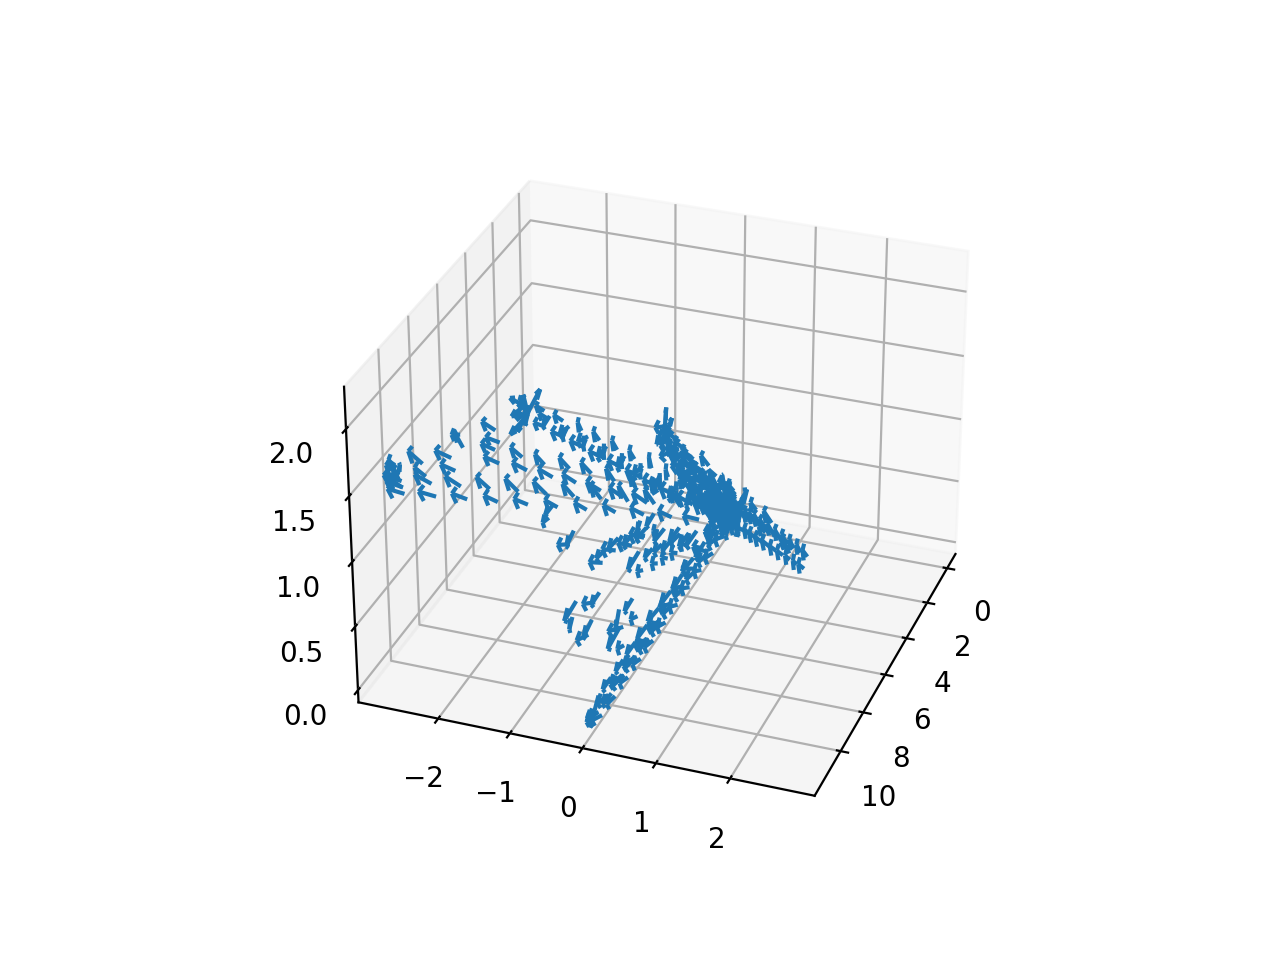

In [25]:
%matplotlib notebook
sdf=pandas.read_csv( os.path.join(config['project_name'], 'case-surface_flow.csv'))
fig2 = plt.figure()
ax21 = fig2.add_subplot(projection='3d', azim=20)
ax21.quiver(sdf['x'], sdf['y'],sdf['z'], sdf['Momentum_x'], sdf['Momentum_y'], sdf['Momentum_z'])
#fig2.show()
#plt.savefig("abc1/quiver.jpg")

! [Force on airplane surfaces](quiver.jpg)

#### Visualize flow solution using external vis package
It's great to know how to build simple data representations, but for more involved analysis we'll use a purpose built tool to look at and analyze our results. Let's generate a single vis frame for one of our sample space simulations, but note that we can interact with the visualization software interactively - as with the Geometry and Meshing, this can be invaluable in trying new things and exploring.

In [9]:
c3['viz_path'] = vis.visualize_case(c3['project_name'], c3)

#display(Image(filename=c3['viz_path'] ))
print(c3['viz_path'])

(   2.679s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fba5b5da180): Refusing to enable OSPRay because it is not supported running in this configuration.
(   3.203s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fba1a7f0e30): Could not determine array range.
(   3.203s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fba1a7f0e30): Could not determine array range.


abc1/case-para.png


![Flow visualization](case-para.png)

#  Dataframes for CFD Ensembles

Often we're concerned with a set of related simulation runs. How should we consider this element and set? A Data Science person might like to consider a single simulation as a row in a dataframe; a CFD practitioner might think of it as an element of a DOE; a designer may just have a bunch of experimenal runs to compare and relate.

It's nice sometimes to think of CFD simulation runs as simply another mapping from an input space to an output space. We may have multiple ways to construct this mapping - for instance: different algorithmic parameters and entire algorithms, precise vs fast CFD and even non-CFD estimates, even experimental data. So rows in the input space will not have unique images in the output space unless we include the mapping used as an input. It can be useful to seperate physical inputs (air temperature), design inputs (fuselage angle), model inputs (mesh size), and algorithmic ones (CFD, linear solver), but here we want to keep things as simple as possible so we'll keep all the inputs "flat" for now.

Each row of our dataframe will contain everything needed to run and analyze a single simulation - a sample from our input space. There may be template files and mesh files which are not part of the dataframe, generally platform specific, but everything needed to generate and use these files will be columns in our dataframe.



We want a dataframe with the input part of every row populated with interesting values. Then for a given mapping we can generate the outputs. We begin by specifying all the static parameters and then varying a subset - the DOE parameters, or a sampling method in the input space, or a set of values of interest. In this case, we will vary the `fuselage_rad` alone - then with `angle of attack` in a simple grid:

We'll uses a  function to add columns to the dataframe for our project, which can involve any of:
* run CFD simulation
* extract values from previously run simulation
* apply estimations (surrogate models) to generate values
* generate sumary and visualization data

So, the return value will be available as a dataframe row.

## Build the dataframe
### First create the rows from sample points:

In [10]:
df = pandas.DataFrame(
    [dict(chain(
            config.items(),
            {
                "case_name": f"{config['project_name']}-{5*i+j:0>3}",
                "fuselage_radians" : 0.15 + 0.02*i,
                "angle_of_attack" : 0.0 + 3.0 * j,
             }.items())) 
     for i in range(5) for j in range(5)])

### Next run simulations and add columns for extracted output
Now we'll add actual models, config, and simulation results to each row. Here we do it all at once with a the helper function mentioned above.

In [11]:
df = pandas.DataFrame(
    [cfd.single_simulation(
        row, make_airplane_model,
        do_extract=['eff_coeff','lift_coeff', 'drag_coeff', 'momentum_z', 'momentum_x'],
        stdout_to_log=True) 
     for row in df.to_dict(orient='records')])

df['aoa_rads'] = df.apply(lambda r:  np.deg2rad(r['angle_of_attack']), axis=1)

So we can do the usual things to explore this space. As a two-dimensional response surface, we can plot this as something like a "carpet plot" with our two parameters against Lift (plotted as height) and Drag (plotted as color).

<IPython.core.display.Javascript object>


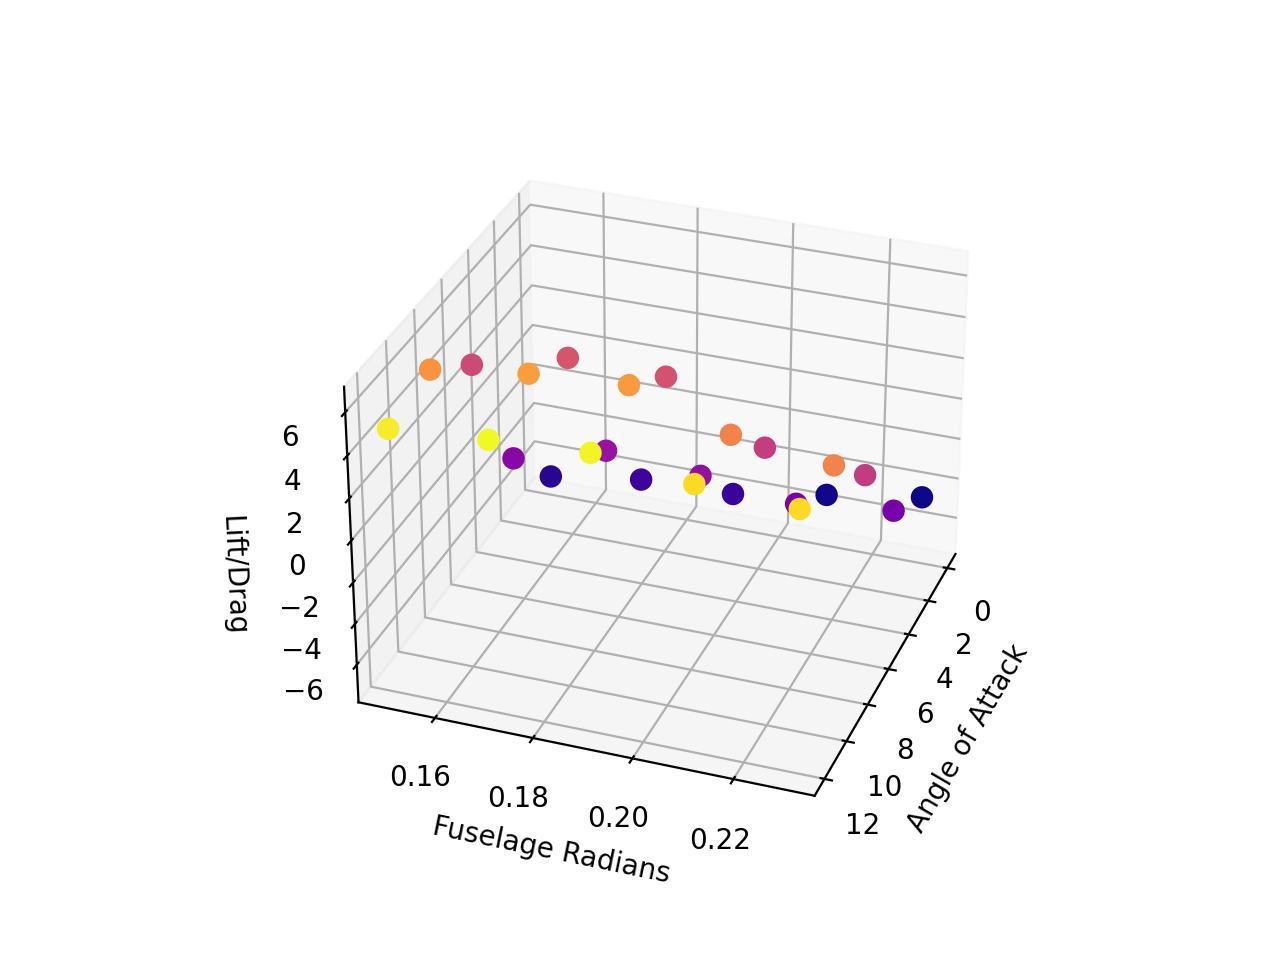

In [12]:
%matplotlib notebook
fig2 = plt.figure()
ax21 = fig2.add_subplot(projection='3d', azim=20)
ax21.scatter3D(df['angle_of_attack'], df['fuselage_radians'],df['eff_coeff'], 
               s=50, alpha=1.0, c=df['lift_coeff'],
               cmap='plasma')
ax21.set_xlabel('Angle of Attack')
ax21.set_ylabel('Fuselage Radians')
ax21.set_zlabel('Lift/Drag')
plt.show()

! [3d scatterplot of design space samples](simple_3d_scatter.png)

## More visualization

### Flow visualization for each sample point

Add visualization images to each case using an external Visualization tool:

In [13]:
df['vispath'] = df.apply(lambda row: vis.visualize_case(row['project_name'], row), axis=1)

(   2.536s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f85c8982ec0): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.981s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f8567ac1d80): Could not determine array range.
(   2.981s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f8567ac1d80): Could not determine array range.
(   1.866s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fcef1784eb0): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.087s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fced2143f80): Could not determine array range.
(   2.087s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fced2143f80): Could not determine array range.
(   1.854s) [paraview        ]    vtkPVRenderView.cxx:

(   1.837s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fb071789520): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.059s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fb071810d10): Could not determine array range.
(   2.059s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7fb071810d10): Could not determine array range.
(   1.856s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f83370a06f0): Refusing to enable OSPRay because it is not supported running in this configuration.
(   2.077s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f82e669ebb0): Could not determine array range.
(   2.077s) [paraview        ]vtkSMPVRepresentationPr:288   WARN| vtkSMPVRepresentationProxy (0x7f82e669ebb0): Could not determine array range.
(   1.864s) [paraview        ]    vtkPVRenderView.cxx:

In [14]:
# vis.html_imgtable(["two", "twelve", "22"],[df.iloc[2]['vispath'], df.iloc[12]['vispath'], df.iloc[22]['vispath']])
display(HTML(vis.html_imgtable(["two", "twelve", "22"],[df.iloc[2]['vispath'], df.iloc[12]['vispath'], df.iloc[22]['vispath']])))

two,twelve,22,,,


! [Three flow visualizations](three_flows.png)

### Simple animation across cases

In [15]:
vis.animate(config, 
                  [df.iloc[2]['vispath'], df.iloc[12]['vispath'], df.iloc[22]['vispath']]
                 )

ffmpeg version N-112441-gc06d3d2404-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxml2 --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-conf

'/Users/scot/Projects/abc1/abc1.gif'

![GIF animation of deisgn sweep](abc1/abc1.gif)

### Persist Dataframe
We will return to this design space and problem in the "Application" sequel to this article, so it's nice to note that we can store the dataframe for direct manipulation, and it includes everything we'll need if we want to run more simulations later.

In [16]:
df.to_csv(f"{config['project_name']}/{config['project_name']}_df.csv")
# df = pandas.read_csv(f"{config['project_name']}/{config['project_name']}_df.csv")

# Applications


## Simple Surrogate Models
To wrap up our example of using this dataframe centered approach to exploring a CFD design space, let's make a simple Surrogate model for our simulation and compare the resulting response surface to the actual CFD data.

<IPython.core.display.Javascript object>


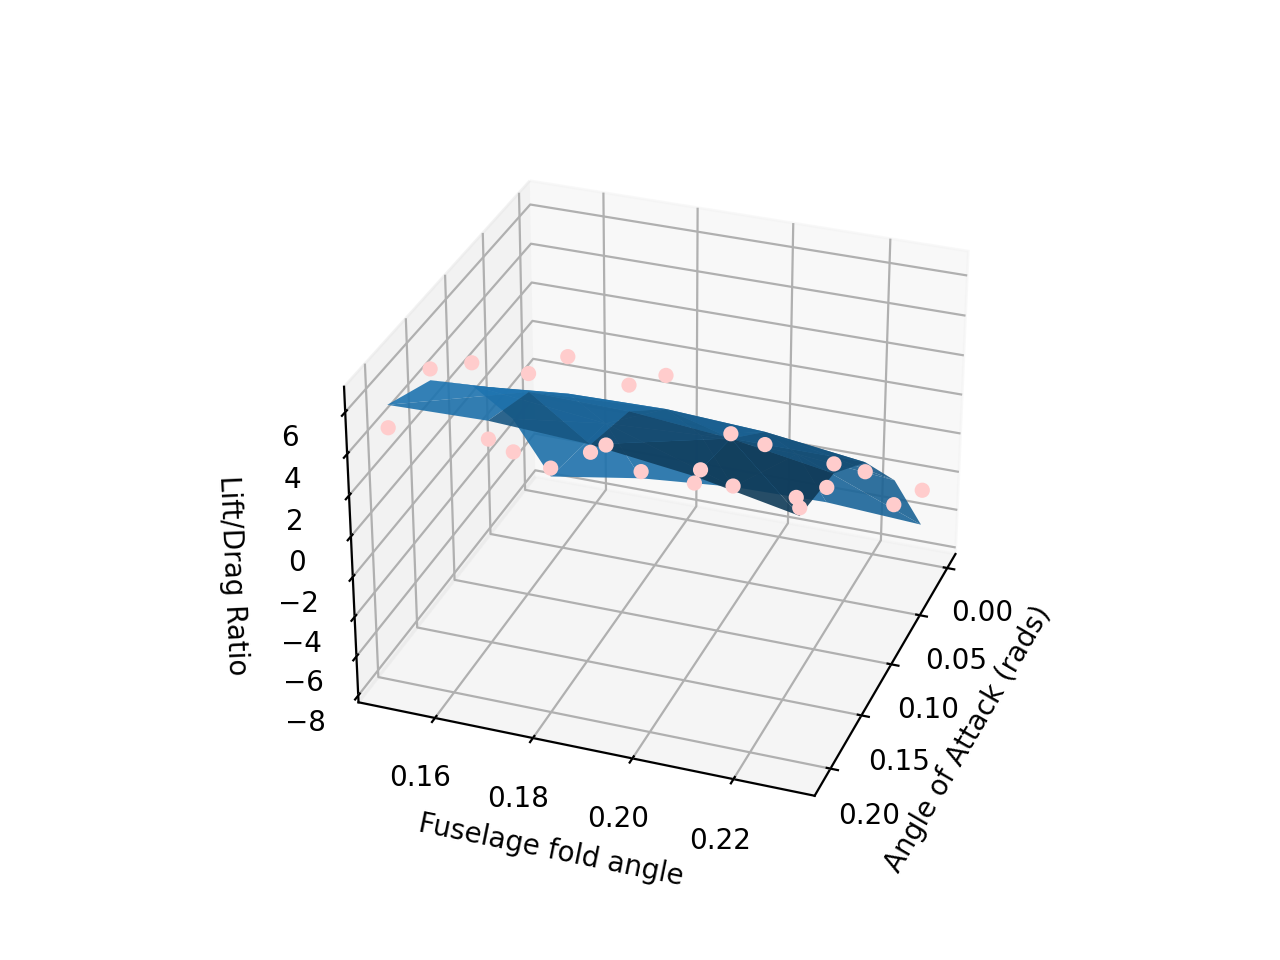

In [17]:
%matplotlib notebook
# build the transform to order-2 polynomials and fit a linear model there:
poly = PolynomialFeatures(2)
pt=poly.fit(df[['angle_of_attack', 'fuselage_radians']])
poly_model = LinearRegression()
poly_model.fit(pt.transform(df[['angle_of_attack', 'fuselage_radians']]), df['eff_coeff'])

# Plot the CFD values against the fit model:
fig2 = plt.figure()
ax21 = fig2.add_subplot(projection='3d', azim=20)
ax21.plot_trisurf(df['aoa_rads'], df['fuselage_radians'],
                poly_model.predict(
                    pt.transform(df[['angle_of_attack', 'fuselage_radians']])),alpha=0.90)
ax21.scatter3D(df['aoa_rads'], df['fuselage_radians'],df['eff_coeff'] , 
               s=20, alpha=1.0, 
               c='#FCC')

# Label and Legend
ax21.set_xlabel("Angle of Attack (rads)")
ax21.set_ylabel("Fuselage fold angle")
ax21.set_zlabel("Lift/Drag Ratio")
fig2.show()
fig2.savefig('carpet_plot.png')

! [Carpet plot](carpet_plot.png)

## AeroDB

Precomputed databases of simulation results are useful in many ways. Later we will use one as a lookup table for Realtime Flight Simulation, but for now we simply use one to add more sample points to our our ensemble of simulations. We often want to add more sample points as we look at the results we've generated so far - hopefully we see an interesting area of the design space we'd like to "zoom in" on. We'll add the new sample points as a new dataframe and populate it, then concatenate it with the first and see if we can draw any conclusions from the overall dataset.


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.6135e-02|   -1.812884|    2.585065|  -15.257108|    1.542074|
|           1|  2.5872e-02|   -2.204377|    2.196779|   -2.876229|    0.532618|
|           2|  2.5837e-02|   -2.330152|    2.067635|   -0.103599|    0.230907|
|           3|  2.5862e-02|   -2.542040|    1.855909|   -0.351785|    0.193974|
|           4|  2.5878e-02|   -2.727752|    1.671146|   -0.415777|    0.170896|
|           5|  2.5749e-02|   -2.880123|    1.520036|   -0.443697|    0.159104|
|           6|  2.5654e-02|   -3.023418|    1.377751|   -0.468273|    0.153408|
|           7|  2.5600e-02|   -3.162215|    1.239775|   -0.482708|    0.149450|
|           8|  2.5662e-02|   -3.295613|    1.107162|   -0.495401|    0.146391|
|           9|  2.5579e-02|   -3.409235|

|         190|  2.5142e-02|   -5.697084|   -1.661996|   -0.588313|    0.128868|
|         191|  2.5140e-02|   -5.700679|   -1.669732|   -0.588312|    0.128869|
|         192|  2.5137e-02|   -5.704404|   -1.677762|   -0.588312|    0.128869|
|         193|  2.5138e-02|   -5.708200|   -1.685486|   -0.588311|    0.128869|
|         194|  2.5137e-02|   -5.712108|   -1.693207|   -0.588310|    0.128869|
|         195|  2.5135e-02|   -5.716151|   -1.701006|   -0.588309|    0.128870|
|         196|  2.5133e-02|   -5.720018|   -1.708427|   -0.588309|    0.128870|
|         197|  2.5131e-02|   -5.724011|   -1.714351|   -0.588308|    0.128870|
|         198|  2.5128e-02|   -5.728443|   -1.722084|   -0.588307|    0.128870|
|         199|  2.5126e-02|   -5.733059|   -1.730279|   -0.588307|    0.128871|
|         200|  2.5123e-02|   -5.737800|   -1.738384|   -0.588306|    0.128871|
+-----------------------------------------------------------------------+
|        File Writing Summary       |         

|         372|  2.5220e-02|   -7.656248|   -3.895813|   -0.588272|    0.128876|
|         373|  2.5218e-02|   -7.662508|   -3.886762|   -0.588272|    0.128876|
|         374|  2.5217e-02|   -7.668647|   -3.877372|   -0.588272|    0.128876|
|         375|  2.5216e-02|   -7.674664|   -3.867829|   -0.588272|    0.128876|
|         376|  2.5215e-02|   -7.680566|   -3.858292|   -0.588272|    0.128876|
|         377|  2.5214e-02|   -7.686373|   -3.848910|   -0.588272|    0.128876|
|         378|  2.5213e-02|   -7.692069|   -3.839762|   -0.588272|    0.128876|
|         379|  2.5211e-02|   -7.697627|   -3.830846|   -0.588272|    0.128876|
|         380|  2.5210e-02|   -7.703072|   -3.822239|   -0.588272|    0.128876|
|         381|  2.5210e-02|   -7.708446|   -3.814024|   -0.588272|    0.128876|
|         382|  2.5210e-02|   -7.713657|   -3.806091|   -0.588272|    0.128876|
|         383|  2.5209e-02|   -7.718704|   -3.798422|   -0.588272|    0.128876|
|         384|  2.5208e-02|   -7.723629|

|         554|  2.5238e-02|   -9.172720|   -5.170455|   -0.588272|    0.128876|
|         555|  2.5239e-02|   -9.183146|   -5.191324|   -0.588272|    0.128876|
|         556|  2.5238e-02|   -9.191794|   -5.209032|   -0.588272|    0.128876|
|         557|  2.5237e-02|   -9.202197|   -5.231376|   -0.588272|    0.128876|
|         558|  2.5237e-02|   -9.212131|   -5.253079|   -0.588272|    0.128876|
|         559|  2.5236e-02|   -9.222520|   -5.276510|   -0.588272|    0.128876|
|         560|  2.5236e-02|   -9.231835|   -5.298413|   -0.588272|    0.128876|
|         561|  2.5235e-02|   -9.242119|   -5.323382|   -0.588272|    0.128876|
|         562|  2.5234e-02|   -9.253466|   -5.351419|   -0.588272|    0.128876|
|         563|  2.5233e-02|   -9.262683|   -5.375263|   -0.588272|    0.128876|
|         564|  2.5233e-02|   -9.272992|   -5.403221|   -0.588272|    0.128876|
|         565|  2.5232e-02|   -9.283078|   -5.431232|   -0.588272|    0.128876|
|         566|  2.5232e-02|   -9.293559|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.5322e-02|   -2.110560|    2.287388|   -4.530546|    0.482825|
|           1|  2.5278e-02|   -2.495172|    1.903308|   -0.510201|    0.318774|
|           2|  2.5286e-02|   -2.559708|    1.836831|    0.241295|    0.211394|
|           3|  2.5329e-02|   -2.711589|    1.685765|    0.021203|    0.163377|
|           4|  2.5414e-02|   -2.878930|    1.520090|   -0.044345|    0.138946|
|           5|  2.5490e-02|   -3.028425|    1.372622|   -0.067222|    0.126579|
|           6|  2.5483e-02|   -3.152315|    1.249948|   -0.089352|    0.119425|
|           7|  2.5490e-02|   -3.267601|    1.135289|   -0.106027|    0.114213|
|           8|  2.5523e-02|   -3.378200|    1.025125|   -0.117862|    0.110056|
|           9|  2.5512e-02|   -3.476377|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.5807e-02|   -2.149699|    2.248250|    6.284505|    0.551708|
|           1|  2.5684e-02|   -2.468813|    1.929790|    1.777637|    0.350716|
|           2|  2.5412e-02|   -2.555654|    1.840473|    0.556629|    0.227426|
|           3|  2.5387e-02|   -2.703525|    1.694342|    0.402724|    0.172255|
|           4|  2.5268e-02|   -2.871058|    1.529317|    0.322909|    0.145876|
|           5|  2.5296e-02|   -3.006852|    1.395123|    0.304190|    0.133427|
|           6|  2.5250e-02|   -3.126488|    1.276158|    0.287247|    0.125142|
|           7|  2.5201e-02|   -3.243887|    1.159056|    0.270052|    0.118483|
|           8|  2.5196e-02|   -3.358951|    1.044025|    0.260241|    0.113350|
|           9|  2.5173e-02|   -3.461800|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.5018e-02|   -1.841920|    2.556028|   17.037173|    1.751053|
|           1|  2.4872e-02|   -2.180711|    2.220358|    4.053595|    0.621999|
|           2|  2.4973e-02|   -2.313799|    2.083542|    0.870845|    0.276555|
|           3|  2.4922e-02|   -2.525239|    1.873355|    0.782673|    0.221116|
|           4|  2.4927e-02|   -2.710681|    1.690085|    0.688891|    0.191309|
|           5|  2.4921e-02|   -2.840537|    1.560914|    0.674567|    0.179234|
|           6|  2.4925e-02|   -2.973140|    1.428500|    0.662977|    0.170374|
|           7|  2.4932e-02|   -3.109663|    1.292064|    0.645513|    0.162231|
|           8|  2.4938e-02|   -3.245015|    1.156586|    0.637902|    0.156345|
|           9|  2.4950e-02|   -3.364986|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.5490e-02|   -1.638236|    2.759712|   27.609528|    4.068342|
|           1|  2.5572e-02|   -1.988008|    2.413621|    6.292509|    1.130238|
|           2|  2.5467e-02|   -2.130030|    2.267717|    1.180423|    0.358580|
|           3|  2.5426e-02|   -2.364295|    2.034511|    1.156982|    0.309649|
|           4|  2.5417e-02|   -2.557748|    1.842914|    1.049837|    0.274997|
|           5|  2.5447e-02|   -2.687803|    1.713212|    1.040178|    0.263802|
|           6|  2.5538e-02|   -2.827916|    1.573100|    1.034037|    0.254940|
|           7|  2.5650e-02|   -2.974797|    1.426159|    1.016558|    0.245305|
|           8|  2.5680e-02|   -3.122205|    1.278507|    1.011291|    0.238909|
|           9|  2.5738e-02|   -3.253645|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.6441e-02|   -1.820770|    2.577179|  -15.755378|    1.560505|
|           1|  2.5775e-02|   -2.206658|    2.194805|   -3.042042|    0.546518|
|           2|  2.5591e-02|   -2.338256|    2.059309|   -0.230644|    0.237598|
|           3|  2.5577e-02|   -2.542301|    1.856130|   -0.522596|    0.198886|
|           4|  2.5528e-02|   -2.719878|    1.679747|   -0.505324|    0.163538|
|           5|  2.5512e-02|   -2.867174|    1.533460|   -0.439358|    0.140650|
|           6|  2.5522e-02|   -3.002910|    1.398379|   -0.447419|    0.132194|
|           7|  2.5481e-02|   -3.141376|    1.260321|   -0.470976|    0.127897|
|           8|  2.5461e-02|   -3.264914|    1.136986|   -0.484865|    0.124021|
|           9|  2.5443e-02|   -3.374796|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.6045e-02|   -2.121115|    2.276833|   -4.644831|    0.484697|
|           1|  2.5933e-02|   -2.499035|    1.899687|   -0.715305|    0.327850|
|           2|  2.6013e-02|   -2.566910|    1.829321|    0.116918|    0.212481|
|           3|  2.5963e-02|   -2.715289|    1.681869|   -0.109460|    0.157992|
|           4|  2.5885e-02|   -2.877893|    1.520935|   -0.125229|    0.126760|
|           5|  2.5819e-02|   -3.014638|    1.386101|   -0.077173|    0.109742|
|           6|  2.5769e-02|   -3.123623|    1.278199|   -0.077921|    0.101042|
|           7|  2.5707e-02|   -3.238725|    1.163577|   -0.098189|    0.095235|
|           8|  2.5651e-02|   -3.345620|    1.056684|   -0.113798|    0.090519|
|           9|  2.5644e-02|   -3.442253|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.5892e-02|   -2.144664|    2.253284|    6.566919|    0.577831|
|           1|  2.5931e-02|   -2.476149|    1.923634|    1.540880|    0.350899|
|           2|  2.5759e-02|   -2.562123|    1.833962|    0.429769|    0.223047|
|           3|  2.5650e-02|   -2.695496|    1.701560|    0.313855|    0.160861|
|           4|  2.5588e-02|   -2.865429|    1.533750|    0.254223|    0.129878|
|           5|  2.5658e-02|   -2.996656|    1.404333|    0.280210|    0.116720|
|           6|  2.5652e-02|   -3.114604|    1.287209|    0.288610|    0.108594|
|           7|  2.5610e-02|   -3.232503|    1.169579|    0.273814|    0.101671|
|           8|  2.5596e-02|   -3.338146|    1.064021|    0.257794|    0.095965|
|           9|  2.5581e-02|   -3.428883|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.5172e-02|   -1.838179|    2.559770|   17.711190|    1.842746|
|           1|  2.5331e-02|   -2.183941|    2.218128|    3.786417|    0.610060|
|           2|  2.5235e-02|   -2.320679|    2.076723|    0.741808|    0.266483|
|           3|  2.5233e-02|   -2.510897|    1.887268|    0.735681|    0.208114|
|           4|  2.5239e-02|   -2.697992|    1.701980|    0.632191|    0.172774|
|           5|  2.5323e-02|   -2.837254|    1.563697|    0.636205|    0.161181|
|           6|  2.5319e-02|   -2.982134|    1.419054|    0.653821|    0.154597|
|           7|  2.5309e-02|   -3.121953|    1.279054|    0.644613|    0.147139|
|           8|  2.5314e-02|   -3.241588|    1.159555|    0.628292|    0.140403|
|           9|  2.5332e-02|   -3.337799|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.5563e-02|   -1.636443|    2.761506|   28.665838|    4.266157|
|           1|  2.5632e-02|   -1.989863|    2.412615|    5.996688|    1.103132|
|           2|  2.5536e-02|   -2.136971|    2.260831|    1.049564|    0.342605|
|           3|  2.5479e-02|   -2.349605|    2.049049|    1.151627|    0.299423|
|           4|  2.5475e-02|   -2.542803|    1.857462|    1.004908|    0.255162|
|           5|  2.5548e-02|   -2.687112|    1.713761|    0.987276|    0.242884|
|           6|  2.5497e-02|   -2.844367|    1.556452|    1.013977|    0.238811|
|           7|  2.5458e-02|   -2.997285|    1.403048|    1.010388|    0.231405|
|           8|  2.5462e-02|   -3.127531|    1.272859|    0.993898|    0.223614|
|           9|  2.5500e-02|   -3.230302|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.4594e-02|   -1.825028|    2.572921|  -15.152919|    1.495885|
|           1|  2.4642e-02|   -2.204091|    2.196947|   -2.570289|    0.501305|
|           2|  2.4620e-02|   -2.348417|    2.049007|   -0.114963|    0.222218|
|           3|  2.4593e-02|   -2.561018|    1.837334|   -0.379314|    0.183810|
|           4|  2.4579e-02|   -2.735290|    1.663887|   -0.398926|    0.154466|
|           5|  2.4599e-02|   -2.888258|    1.511418|   -0.382061|    0.135610|
|           6|  2.4629e-02|   -3.026604|    1.373613|   -0.378999|    0.126091|
|           7|  2.4621e-02|   -3.163202|    1.237581|   -0.379714|    0.120965|
|           8|  2.4607e-02|   -3.291993|    1.109321|   -0.375689|    0.117114|
|           9|  2.4594e-02|   -3.404765|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.4615e-02|   -2.128195|    2.269754|   -4.291804|    0.469815|
|           1|  2.4628e-02|   -2.505731|    1.892913|   -0.407910|    0.317321|
|           2|  2.4600e-02|   -2.581812|    1.814542|    0.271222|    0.206011|
|           3|  2.4586e-02|   -2.732607|    1.664744|    0.031619|    0.152824|
|           4|  2.4568e-02|   -2.889705|    1.508952|   -0.028229|    0.124136|
|           5|  2.4569e-02|   -3.035523|    1.364378|   -0.013082|    0.108106|
|           6|  2.4570e-02|   -3.156338|    1.244444|   -0.010186|    0.099399|
|           7|  2.4563e-02|   -3.277064|    1.124396|   -0.015252|    0.094103|
|           8|  2.4555e-02|   -3.393013|    1.008955|   -0.015233|    0.090287|
|           9|  2.4546e-02|   -3.497109|

+-----------------------------------------------------------------------+
|        File Writing Summary       |              Filename             |
+-----------------------------------------------------------------------+
|SU2 binary restart                 |abc1/restart_flow.dat              |
|Paraview                           |abc1/abc1_zoom-011-flow.vtu        |
|Paraview surface                   |abc1/abc1_zoom-011-surface_flow.vtu|
|CSV file                           |abc1/abc1_zoom-011-surface_flow.csv|
|SU2 ASCII restart                  |abc1/restart_flow.csv              |
+-----------------------------------------------------------------------+

------------------------- Solver Postprocessing -------------------------
Deleted CNumerics container.
Deleted CIntegration container.
Deleted CSolver container.
Deleted CIteration container.
Deleted CInterface container.
Deleted CGeometry container.
Deleted CFreeFormDefBox class.
Deleted CSurfaceMovement class.
Deleted CVolumetric

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.4613e-02|   -2.137244|    2.260705|    6.669997|    0.586421|
|           1|  2.4552e-02|   -2.468573|    1.931225|    1.669941|    0.357237|
|           2|  2.4590e-02|   -2.567153|    1.829442|    0.635774|    0.229889|
|           3|  2.4628e-02|   -2.707360|    1.690048|    0.450055|    0.165257|
|           4|  2.4635e-02|   -2.877236|    1.521597|    0.339302|    0.132604|
|           5|  2.4644e-02|   -3.017421|    1.382668|    0.354106|    0.119273|
|           6|  2.4641e-02|   -3.142483|    1.258296|    0.357911|    0.111373|
|           7|  2.4634e-02|   -3.266318|    1.134871|    0.348923|    0.105447|
|           8|  2.4628e-02|   -3.383802|    1.017793|    0.345172|    0.101248|
|           9|  2.4633e-02|   -3.490624|

|         736|  2.6172e-02|   -9.891647|   -5.558387|    0.315402|    0.080354|
|         737|  2.6170e-02|   -9.901489|   -5.569383|    0.315402|    0.080354|
|         738|  2.6168e-02|   -9.911150|   -5.580305|    0.315402|    0.080354|
|         739|  2.6166e-02|   -9.920699|   -5.590893|    0.315402|    0.080354|
|         740|  2.6163e-02|   -9.929912|   -5.601281|    0.315402|    0.080354|
|         741|  2.6161e-02|   -9.939065|   -5.611483|    0.315402|    0.080354|
|         742|  2.6158e-02|   -9.947680|   -5.621177|    0.315402|    0.080354|
|         743|  2.6156e-02|   -9.956236|   -5.630792|    0.315402|    0.080354|
|         744|  2.6153e-02|   -9.964397|   -5.639659|    0.315402|    0.080354|
|         745|  2.6152e-02|   -9.972493|   -5.648640|    0.315402|    0.080354|
|         746|  2.6151e-02|   -9.980014|   -5.656550|    0.315402|    0.080354|
|         747|  2.6150e-02|   -9.987610|   -5.664708|    0.315402|    0.080354|
|         748|  2.6149e-02|   -9.994400|

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.4279e-02|   -1.831687|    2.566261|   17.563183|    1.848555|
|           1|  2.4268e-02|   -2.172810|    2.228887|    3.736071|    0.614504|
|           2|  2.4212e-02|   -2.320863|    2.076668|    0.998025|    0.291979|
|           3|  2.4206e-02|   -2.522983|    1.875320|    0.866527|    0.221549|
|           4|  2.4208e-02|   -2.713609|    1.685754|    0.705294|    0.179607|
|           5|  2.4252e-02|   -2.857882|    1.542087|    0.719623|    0.168939|
|           6|  2.4260e-02|   -3.000157|    1.400086|    0.724359|    0.161943|
|           7|  2.4248e-02|   -3.141040|    1.259270|    0.711682|    0.154991|
|           8|  2.4242e-02|   -3.272723|    1.127840|    0.704348|    0.150026|
|           9|  2.4226e-02|   -3.389634|

|         736|  2.4724e-02|   -9.816372|   -5.482849|    0.723181|    0.131234|
|         737|  2.4723e-02|   -9.826387|   -5.494034|    0.723181|    0.131234|
|         738|  2.4723e-02|   -9.835845|   -5.504908|    0.723181|    0.131234|
|         739|  2.4722e-02|   -9.845038|   -5.515189|    0.723181|    0.131234|
|         740|  2.4721e-02|   -9.854398|   -5.525596|    0.723181|    0.131234|
|         741|  2.4720e-02|   -9.863403|   -5.535595|    0.723181|    0.131234|
|         742|  2.4719e-02|   -9.872299|   -5.545298|    0.723181|    0.131234|
|         743|  2.4719e-02|   -9.881034|   -5.554972|    0.723181|    0.131234|
|         744|  2.4718e-02|   -9.889258|   -5.563840|    0.723181|    0.131234|
|         745|  2.4717e-02|   -9.897488|   -5.572733|    0.723181|    0.131234|
|         746|  2.4716e-02|   -9.904999|   -5.580847|    0.723181|    0.131234|
|         747|  2.4716e-02|   -9.912872|   -5.589048|    0.723181|    0.131234|
|         748|  2.4715e-02|   -9.920211|

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.4245e-02|   -1.631638|    2.766311|   28.268314|    4.242946|
|           1|  2.4203e-02|   -1.979256|    2.422777|    5.767744|    1.086890|
|           2|  2.4140e-02|   -2.137207|    2.260564|    1.353939|    0.391924|
|           3|  2.4121e-02|   -2.362785|    2.035887|    1.276615|    0.321345|
|           4|  2.4114e-02|   -2.560225|    1.839344|    1.066010|    0.264872|
|           5|  2.4181e-02|   -2.707775|    1.692086|    1.079777|    0.256830|
|           6|  2.4411e-02|   -2.858111|    1.541831|    1.085432|    0.250845|
|           7|  2.4466e-02|   -3.008113|    1.391727|    1.069351|    0.242507|
|           8|  2.4485e-02|   -3.148546|    1.251423|    1.058635|    0.236420|
|           9|  2.4461e-02|   -3.271731|

|         736|  2.6235e-02|   -9.723840|   -5.386234|    1.123310|    0.224354|
|         737|  2.6252e-02|   -9.733474|   -5.397123|    1.123310|    0.224354|
|         738|  2.6254e-02|   -9.743394|   -5.408244|    1.123310|    0.224354|
|         739|  2.6251e-02|   -9.752997|   -5.419071|    1.123310|    0.224354|
|         740|  2.6248e-02|   -9.762614|   -5.429951|    1.123310|    0.224354|
|         741|  2.6249e-02|   -9.772116|   -5.440492|    1.123310|    0.224354|
|         742|  2.6260e-02|   -9.781444|   -5.450863|    1.123310|    0.224354|
|         743|  2.6261e-02|   -9.790675|   -5.461030|    1.123310|    0.224354|
|         744|  2.6273e-02|   -9.799657|   -5.470830|    1.123310|    0.224354|
|         745|  2.6271e-02|   -9.808574|   -5.480486|    1.123310|    0.224354|
|         746|  2.6276e-02|   -9.817283|   -5.489911|    1.123310|    0.224354|
|         747|  2.6283e-02|   -9.825858|   -5.498850|    1.123310|    0.224354|
|         748|  2.6282e-02|   -9.834234|

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.4636e-02|   -1.827942|    2.570006|  -14.903085|    1.444948|
|           1|  2.4464e-02|   -2.205245|    2.195280|   -3.015366|    0.507179|
|           2|  2.4438e-02|   -2.335113|    2.062669|   -0.330290|    0.220301|
|           3|  2.4407e-02|   -2.561947|    1.836587|   -0.566013|    0.184637|
|           4|  2.4383e-02|   -2.749786|    1.649755|   -0.623286|    0.163130|
|           5|  2.4385e-02|   -2.879739|    1.520581|   -0.600138|    0.148423|
|           6|  2.4412e-02|   -3.013401|    1.387453|   -0.567376|    0.138261|
|           7|  2.4410e-02|   -3.152965|    1.248263|   -0.545824|    0.131149|
|           8|  2.4396e-02|   -3.279882|    1.121596|   -0.541698|    0.126556|
|           9|  2.4384e-02|   -3.383691|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.4453e-02|   -2.133809|    2.264140|   -4.080754|    0.443333|
|           1|  2.4309e-02|   -2.508174|    1.890746|   -0.618339|    0.299492|
|           2|  2.4257e-02|   -2.573630|    1.823610|    0.054711|    0.192127|
|           3|  2.4261e-02|   -2.722801|    1.674996|   -0.163301|    0.142395|
|           4|  2.4254e-02|   -2.891641|    1.507132|   -0.230390|    0.118642|
|           5|  2.4279e-02|   -3.032838|    1.366991|   -0.200920|    0.106904|
|           6|  2.4303e-02|   -3.151830|    1.248784|   -0.164760|    0.099795|
|           7|  2.4299e-02|   -3.267041|    1.134457|   -0.147776|    0.094371|
|           8|  2.4294e-02|   -3.370967|    1.031384|   -0.146483|    0.090049|
|           9|  2.4286e-02|   -3.458568|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.4886e-02|   -2.128172|    2.269777|    6.836435|    0.580046|
|           1|  2.4773e-02|   -2.456293|    1.943825|    1.697920|    0.340594|
|           2|  2.4610e-02|   -2.546137|    1.851111|    0.417101|    0.203765|
|           3|  2.4526e-02|   -2.684536|    1.713477|    0.249083|    0.142803|
|           4|  2.4462e-02|   -2.855362|    1.543779|    0.161153|    0.115351|
|           5|  2.4486e-02|   -3.006891|    1.393031|    0.195788|    0.107227|
|           6|  2.4584e-02|   -3.133776|    1.266607|    0.235991|    0.103544|
|           7|  2.4616e-02|   -3.243599|    1.157369|    0.249425|    0.099346|
|           8|  2.4608e-02|   -3.346491|    1.055277|    0.248973|    0.095023|
|           9|  2.4615e-02|   -3.437630|

Context leak detected, msgtracer returned -1



-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.4648e-02|   -1.823809|    2.574140|   17.683408|    1.857525|
|           1|  2.4648e-02|   -2.163346|    2.237878|    4.001134|    0.623972|
|           2|  2.4727e-02|   -2.297051|    2.100661|    0.778588|    0.253465|
|           3|  2.4688e-02|   -2.504443|    1.894271|    0.661132|    0.186531|
|           4|  2.4643e-02|   -2.691306|    1.708583|    0.552596|    0.153200|
|           5|  2.4598e-02|   -2.837280|    1.563038|    0.592139|    0.149221|
|           6|  2.4721e-02|   -2.977547|    1.422788|    0.636094|    0.149377|
|           7|  2.4684e-02|   -3.104737|    1.295474|    0.645964|    0.146033|
|           8|  2.4643e-02|   -3.227478|    1.172914|    0.643852|    0.141531|
|           9|  2.4612e-02|   -3.336247|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.4566e-02|   -1.625443|    2.772505|   28.341222|    4.262374|
|           1|  2.4438e-02|   -1.971704|    2.429687|    6.266011|    1.147127|
|           2|  2.4402e-02|   -2.114203|    2.283647|    1.135168|    0.341030|
|           3|  2.4438e-02|   -2.348450|    2.050547|    1.068514|    0.273424|
|           4|  2.4438e-02|   -2.542689|    1.857512|    0.939982|    0.232075|
|           5|  2.4455e-02|   -2.683907|    1.716583|    0.984087|    0.232748|
|           6|  2.4531e-02|   -2.829122|    1.571233|    1.031448|    0.237124|
|           7|  2.4541e-02|   -2.967066|    1.432816|    1.037779|    0.234270|
|           8|  2.4531e-02|   -3.102593|    1.297000|    1.034134|    0.229428|
|           9|  2.4516e-02|   -3.223086|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.3782e-02|   -1.832018|    2.565931|  -14.549614|    1.428862|
|           1|  2.3633e-02|   -2.223618|    2.177568|   -2.618947|    0.513548|
|           2|  2.3549e-02|   -2.346112|    2.051077|   -0.331059|    0.254102|
|           3|  2.3525e-02|   -2.568892|    1.829218|   -0.527652|    0.210887|
|           4|  2.3515e-02|   -2.746220|    1.653334|   -0.526768|    0.181759|
|           5|  2.3578e-02|   -2.888355|    1.512308|   -0.486950|    0.163261|
|           6|  2.3603e-02|   -3.029295|    1.372031|   -0.456198|    0.152936|
|           7|  2.3588e-02|   -3.168550|    1.233060|   -0.450955|    0.147383|
|           8|  2.3581e-02|   -3.298392|    1.103297|   -0.463282|    0.144070|
|           9|  2.3572e-02|   -3.407970|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.4214e-02|   -2.140344|    2.257605|   -3.821241|    0.456738|
|           1|  2.3996e-02|   -2.506640|    1.891282|   -0.491849|    0.329831|
|           2|  2.3898e-02|   -2.572078|    1.823591|    0.109382|    0.222858|
|           3|  2.3865e-02|   -2.736007|    1.660525|   -0.087519|    0.167074|
|           4|  2.3840e-02|   -2.910070|    1.488484|   -0.140822|    0.140172|
|           5|  2.3831e-02|   -3.047674|    1.352749|   -0.104933|    0.127751|
|           6|  2.3908e-02|   -3.160832|    1.240454|   -0.071809|    0.121190|
|           7|  2.3904e-02|   -3.279293|    1.122546|   -0.066262|    0.116128|
|           8|  2.3896e-02|   -3.391964|    1.010309|   -0.077316|    0.111697|
|           9|  2.3890e-02|   -3.486595|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.3765e-02|   -2.120444|    2.277505|    6.996586|    0.612932|
|           1|  2.3650e-02|   -2.440852|    1.958641|    1.554257|    0.366416|
|           2|  2.3603e-02|   -2.539352|    1.856598|    0.529493|    0.237387|
|           3|  2.3589e-02|   -2.698845|    1.698229|    0.365749|    0.169974|
|           4|  2.3578e-02|   -2.886391|    1.512299|    0.243763|    0.139048|
|           5|  2.3587e-02|   -3.019901|    1.379997|    0.276552|    0.132352|
|           6|  2.3591e-02|   -3.134321|    1.266044|    0.314176|    0.129849|
|           7|  2.3599e-02|   -3.253788|    1.146993|    0.320680|    0.125302|
|           8|  2.3606e-02|   -3.366613|    1.034853|    0.310779|    0.119872|
|           9|  2.3602e-02|   -3.463435|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.4307e-02|   -1.817458|    2.580490|   17.742897|    1.899419|
|           1|  2.4365e-02|   -2.165497|    2.236328|    3.589700|    0.617107|
|           2|  2.4101e-02|   -2.298728|    2.098520|    0.947623|    0.295963|
|           3|  2.3984e-02|   -2.515053|    1.883480|    0.817508|    0.220396|
|           4|  2.3890e-02|   -2.710920|    1.688655|    0.627726|    0.178291|
|           5|  2.3842e-02|   -2.846920|    1.552967|    0.657173|    0.176996|
|           6|  2.3928e-02|   -2.983176|    1.416638|    0.698993|    0.179016|
|           7|  2.3934e-02|   -3.118694|    1.280924|    0.706554|    0.175097|
|           8|  2.3912e-02|   -3.246268|    1.153681|    0.698032|    0.168804|
|           9|  2.3893e-02|   -3.357915|


-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                            |
-------------------------------------------------------------------------
| Copyright 2012-2023, SU2 Contributors                                 |
|                                    

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  2.3729e-02|   -1.620711|    2.777238|   28.299913|    4.302741|
|           1|  2.3620e-02|   -1.979405|    2.422910|    5.591846|    1.079794|
|           2|  2.3575e-02|   -2.118876|    2.278744|    1.359086|    0.398208|
|           3|  2.3593e-02|   -2.357227|    2.041859|    1.263085|    0.318012|
|           4|  2.3604e-02|   -2.554259|    1.845692|    1.007242|    0.257729|
|           5|  2.3685e-02|   -2.692229|    1.707755|    1.033086|    0.261500|
|           6|  2.3732e-02|   -2.839259|    1.560458|    1.078714|    0.268478|
|           7|  2.3769e-02|   -2.983827|    1.415339|    1.087422|    0.265319|
|           8|  2.3810e-02|   -3.120901|    1.278218|    1.080481|    0.258326|
|           9|  2.3797e-02|   -3.242504|

<IPython.core.display.Javascript object>


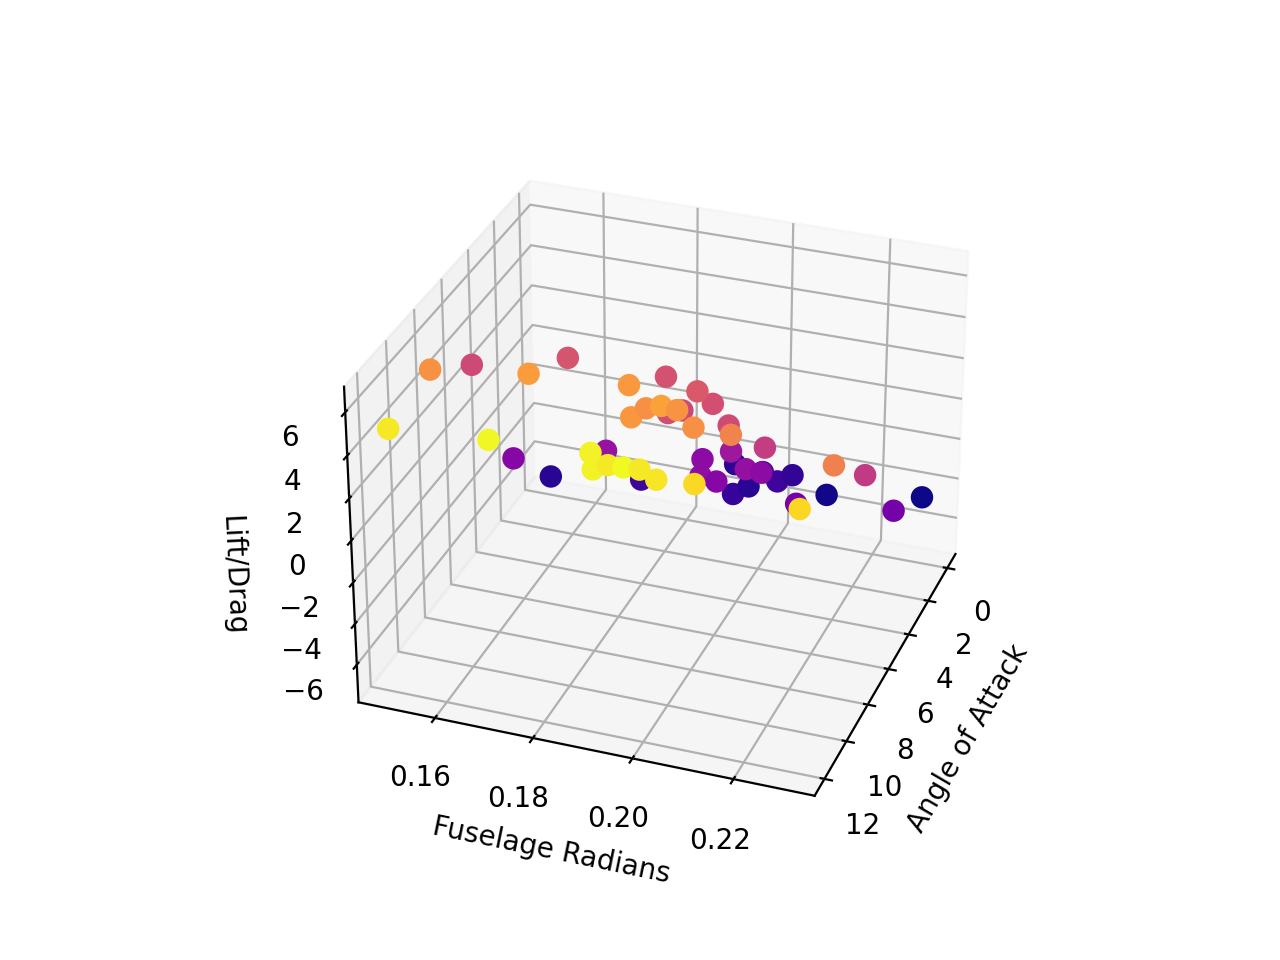

Text(0.5, 0, 'Lift/Drag')

In [18]:

zoomed_params = [geometry.pi/x for x in [15.5, 15.75,16.0,16.25,16.5]]
df2 = pandas.DataFrame(
    [dict(
        chain(
            config.items(),
            {#"project_name": project_name,
                "case_name": f"{config['project_name']}_zoom-{5*i+j:0>3}",
                "fuselage_radians" : zoomed_params[i],
                "angle_of_attack" : 0.0 + 3.0 * j
             }.items()
        )
    ) for i in range(5) for j in range(5)])

df2 = pandas.DataFrame(
    [cfd.single_simulation(
        row, make_airplane_model,
        do_extract=['eff_coeff','lift_coeff', 'drag_coeff', 'momentum_z', 'momentum_x'],
        stdout_to_log=False,
        define_surface_groups=True) 
     for row in df2.to_dict(orient='records')])

df = pandas.concat([df,df2],axis=0)

%matplotlib notebook
fig4 = plt.figure()
ax4 = fig4.add_subplot(projection='3d', azim=20)
ax4.scatter3D(df['angle_of_attack'], df['fuselage_radians'],df['eff_coeff'], 
               s=50, alpha=1.0, c=df['lift_coeff'],
               cmap='plasma')
ax4.set_xlabel('Angle of Attack')
ax4.set_ylabel('Fuselage Radians')
ax4.set_zlabel('Lift/Drag')

At this point, we have a dataframe with all the parameters and simulation outputs as rows. 
Let's add a Angle of Attack in Radians to make it easier to relate to our fold.
Here we pull some interesting values out for a specific value of our Angle of Attack by way of example:

In [19]:
df[df.angle_of_attack==6][['angle_of_attack', 'aoa_rads', 'fuselage_radians', 'eff_coeff','case_name']]\
    .sort_values(by=['fuselage_radians'])


,angle_of_attack,aoa_rads,fuselage_radians,eff_coeff,case_name
2,6.0,0.10472,0.150000,3.300982,abc1-002
7,6.0,0.10472,0.170000,4.439118,abc1-007
12,6.0,0.10472,0.190000,4.356859,abc1-012
22,6.0,NaN,0.190400,2.644385,abc1_zoom-022
17,6.0,NaN,0.193329,2.890754,abc1_zoom-017
12,6.0,NaN,0.196350,3.925132,abc1_zoom-012
7,6.0,NaN,0.199466,3.460984,abc1_zoom-007
2,6.0,NaN,0.202683,2.564205,abc1_zoom-002
17,6.0,0.10472,0.210000,1.817577,abc1-017
22,6.0,0.10472,0.230000,1.363224,abc1-022


# Design Optimization

This is all fun, but we haven't answered our question. How should we make that last fold on a "dart" style paper airplane?

What does that even mean. The optimal fold will be corellated with the throw angle (angle of attack) since the angle of the wing means that if thrown parallel to the baseline of the fuselage, the wing will be pointing down and generating negative lift. We calculated for a rangle of throw angles, and don't know what people will actually do, so we'll just average across those and find the best `fuselage_angle` for the resulting one dimensional optimization.

### Simple averaging

We assume a uniform distribution of the release angle (and hence Angle of Attack). This is likely unrealistic, but it means we can just take a simple average across that axis to yield a simple function of the fold angle:

In [20]:
avg_aoa=df.groupby('fuselage_radians')
# avg_aoa.max()['eff_coeff']
aoa=list(avg_aoa.indices.keys())

Note that if we weight our throw angles to something more realistic we get something fairly close to the experimental values from the above paper, which is nice:

In [21]:
avg_aoa.apply(lambda x: np.average(x['eff_coeff'],weights=[0.1,0.1,0.4,0.2,0.2]))

fuselage_radians
0.150000    2.291793
0.170000    3.130952
0.190000    3.179673
0.190400    2.292219
0.193329    2.361789
0.196350    3.076892
0.199466    2.777357
0.202683    2.261614
0.210000    1.789105
0.230000    1.572073
dtype: float64

<IPython.core.display.Javascript object>


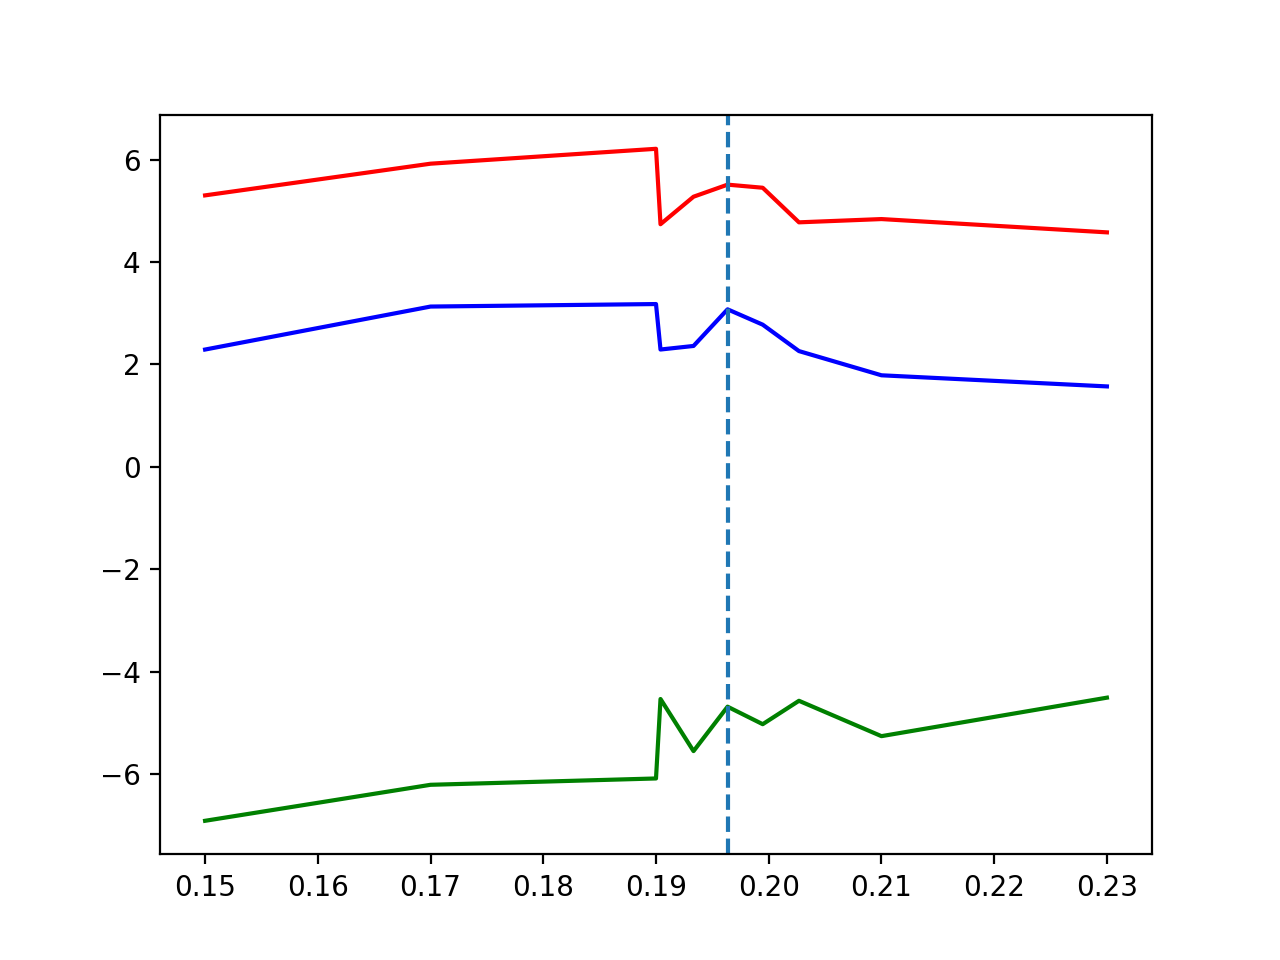

In [22]:
fig3 = plt.figure()
plt.plot(aoa, avg_aoa.max()['eff_coeff'],c='red')
plt.plot(aoa, avg_aoa.min()['eff_coeff'],c='green')
plt.plot(aoa, avg_aoa.apply(lambda x: np.average(x['eff_coeff'],weights=[0.1,0.1,0.4,0.2,0.2])) ,c='blue')
plt.axvline(x=geometry.pi/16.0,ls='--')
fig3.show()
fig3.savefig('eff.png')

This would seem to suggest that folding the wings a little past the fuselage line, rather than the traditional 'dart' fold of $/pi / 16$, is optimal. Not too far though, or the added drag reduces the efficiency. Note however that we're assuming a lot since we don't estimate right on that point. Let's zoom in and add some granularity closer to that critical point:

### Integrate out the fold angle instead - find best launch angle

Taking another literal perspective, we can integrate out the design parameter and take a guess that the optimal angle to throw our paper airplane is around $9^{\circ}$

<IPython.core.display.Javascript object>


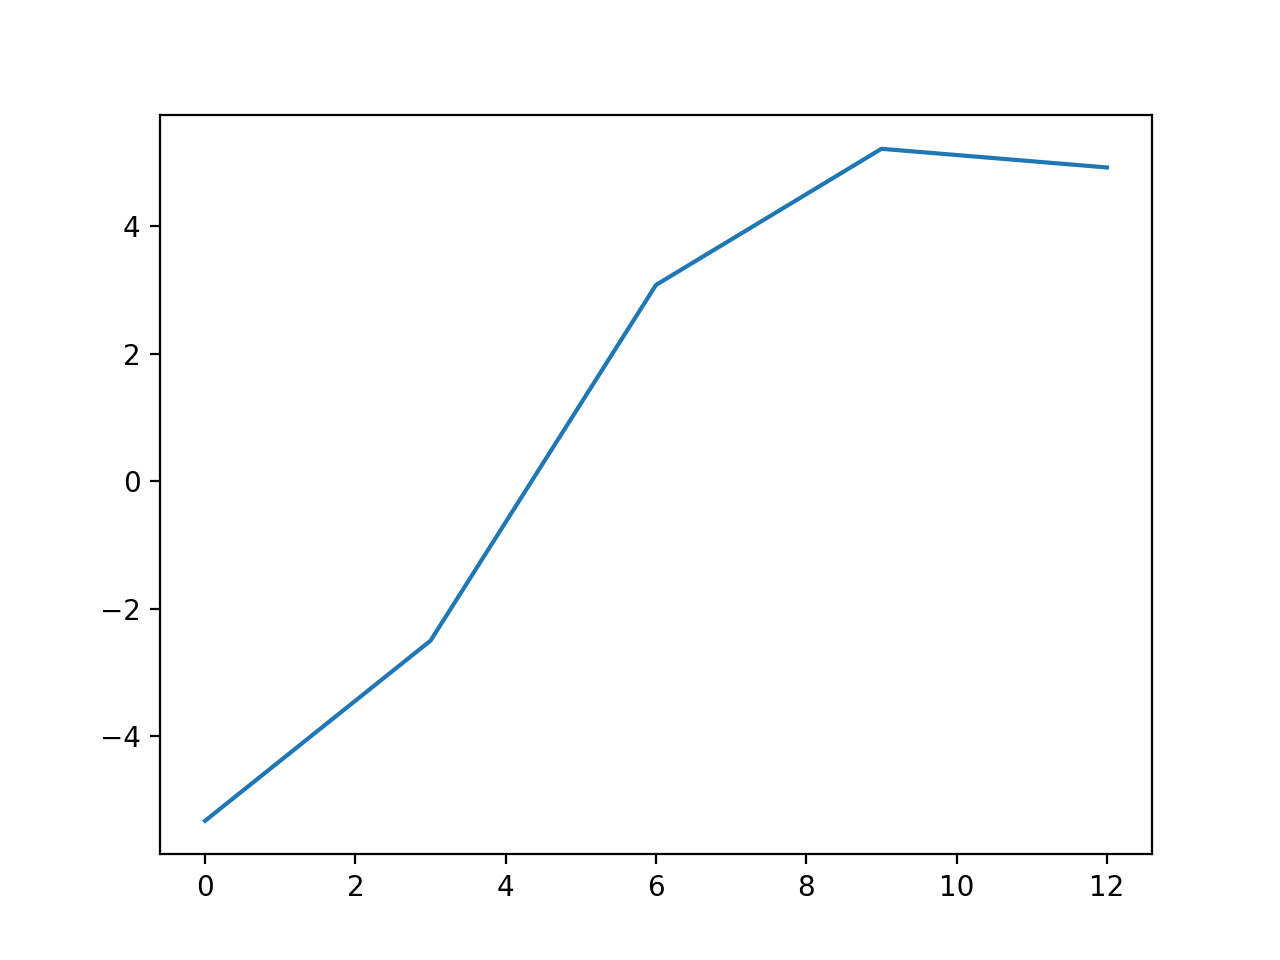

/var/folders/ty/h70sdx715cl5sdlg578tl3mh0000gn/T/ipykernel_57536/1290379252.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot(df.groupby('angle_of_attack').mean()['eff_coeff'])


In [24]:
fig4=plt.figure()
plt.plot(df.groupby('angle_of_attack').mean()['eff_coeff'])
fig4.show()

# Results

## Do our CFD results seem reasonable?

## Does our optimization seem reasonable?

## How does clever optimization compare to a grid search?

# Open Questions and Next Steps

* Try running the `single_simulation` examples above with `interactive=True`. This will bring up `gmsh` or `paraview` (resp.) to let you move around camera angles and play with parameters, and is a wonderful exploratory mode to work in.
* What is going on with the dip in aerodynamic efficacy as the wing goes just past the exact edge of the fuselage (at $pi/32$). The sharp dip suggests something interesting - very likely, a bug in our geometry code; most likely, the naively simple simulation approach creating unphysical behaviors; or least likely, an actual critical point of some kind in the physics. 

* Should the angle of attack be normalized to the fold angle, so the wing is always at $0^{\circ}$?
* Optimization tools (Dakota, matlab, etc)
* CFD tooling
  * cfd params
  * mesh improvements
  * other CFD platforms
* problem refinement
* more parameter dimensions
* V & V

Now that we can see the general response surface, it would make sense to delve into how to run our simulation enemble more efficiently. We might use "Total Run Time" or something like convergence to generate a response surface while we vary things like mesh size or other alogorithmic parameters. We also can see it would be interesting to explore a larger patch of the `(AoA, FuselageAngle)` space. 

That means we're at a good point to end this notebook - we are exploring properties of the space using dataframes in a notebook in a way that faciliates ensemble thinking. In later notebooks, we'll look at using this ability for a range of applications and modelling improvements.




## simulation optimization

### variable mesh size and granularity

### other algorithmic parameters

### 

## design optimization

What is an interesting AoA to optimize along?

What are useful physical parameters?

Do our result make physical sense?

How should we define fitness?

How should we optimize fitness with our single variable?

Dakota Project

# Colophon


## Workbench - which tools will we use?

We begin using Open Source tools anyone can run on a personal computer and develop a workbench which will allow later exploration of more aggressive (and non-free in all senses) environments and tools.

Readers hailing from the systems side will note that we use shell and file interfaces in some places a cleaner direct API could be used. This is intentional, but not a requirement. It's useful because a number of simulation tools tend to take this configuration file approach and because it makes it's easier to, for example, pull a directory of image files into a movie with `ffmpeg` than to sort out a live interface for doing so. It also makes it easy to decouple components - we try to use light interfaces, so switching CFD engines or visualization should be mostly independent of the high level workflow. It is certainly possible to use clean/direct APIs when available, as we do for interacting with constructive solid geometry for example.

Fundamentally we want to work with Python Notebooks as a way to elegantly tie together multiple tools and platforms into coherent workflows, orchestrate computation, and analyze results. So will prefer tools that best allow this.

## Dataframes and ML
We want to have a familiar way to work with arrays of data and tools for processing them.

A primary goal here is to treat the exploration of a design space as simply mapping problem parameters to objective functions. That is, we'd like to take some geometry and simulation configuration values (input vector) and map them to some estimated physical/computational results (output vector). Note that this is classic Data Science, and so we'd like to keep a DataFrame (Pandas, for now) at the center of our work.

Note that as our design spaces grow, this naturally allows parallelization. Using Spark dataframes, for example, affords scalable parallelism via drop-in replacement and less sophisticated but servicable approaches are possible on cloud platforms.

## Geometry and Meshing
We use `gmsh` for both Parametric CAD and our Meshing. The python interface makes this pleasant-ish We will explore varying geometric parameters by rebuilding geometries and then meshes for different values. We will generate `gmsh` output files as well as....

## CFD

We use SU2 for this first foray.

We plan to make versions with other free options and commercial tools.

## Analysis
We will aggregate the tabular outputs from SU2 and process them using Pandas, Numpy, and other common DS tools . Higher level analysis and visualization will be done with Paraview.

## Optimization

Given a fully populated DOEFrame we can fit a simple model and optimize that using standard tools like `scikit-learn` and similar.